# Etapa 1: Regresión lineal

Este es un modelo de regresión lineal que permite determinar la demanda sobre el uso de un sistema de alquiler de bicicletas. Esto con el proposito de mejorar el servicio y conocer los factores que inciden en su eficiencia, con el fin de fomentar planes de movilidad sostenible que permitan reducir las emisiones de CO2.

## 1. Exploración y perfilamiento de datos

Inicialmente se debe hacer un reconocimiento de los datos con los cuales se van a trabajar, definir la variable objetivo y conocer las variables independientes que estadisticamente esten relacionadas a dicha variable objetivo.

### Importación de las librerias a usar.

Se deben importar las librerias que vamos a necesitar para definir el modelo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.pipeline import make_pipeline

### **Carga de datos:** 
Luego de haber importado las librerias que se necesitan para el modelo se debe cargar los datos con los cuales se va a entrenar y evaluar. **(se recomienda cargar los datos como un archivo .csv)**.

Para poder explorar los datos cargados usamos funciones de Python que nos permitan visualizar la cantidad de filas y columnas que tiene nuesto dataset y tambien nos proporcione información general de las variables numericas.

In [2]:
df = pd.read_csv('datos_etapa1.csv', sep=',')
df.head()

,season,weekday,weathersit,temp,atemp,hum,windspeed,cnt,time_of_day
0,Winter,6,Clear,3.28,3.0014,0.81,0.0,16,Night
1,Winter,6,Clear,2.34,1.9982,0.80,0.0,40,Night
2,Winter,6,Clear,2.34,1.9982,0.80,0.0,32,Night
3,Winter,6,Clear,3.28,3.0014,0.75,0.0,13,Night
4,Winter,6,Clear,3.28,3.0014,0.75,0.0,1,Night


In [3]:
df.shape

(17379, 9)

In [4]:
df.describe()

,weekday,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,3.003683,15.358397,15.401157,0.627229,12.736540,189.463088
std,2.005771,9.050138,11.342114,0.192930,8.196795,181.387599
min,0.000000,-7.060000,-16.000000,0.000000,0.000000,1.000000
25%,1.000000,7.980000,5.997800,0.480000,7.001500,40.000000
50%,3.000000,15.500000,15.996800,0.630000,12.998000,142.000000
75%,5.000000,23.020000,24.999200,0.780000,16.997900,281.000000
max,6.000000,39.000000,50.000000,1.000000,56.996900,977.000000


Luego de realizar una exploración sencilla de los datos se ha definido que la variable objetivo para este modelo de regresión lineal sera la columna **"cnt"** que corresponde a **cantidad de biciletas rentadas**. Para definir cuales son las variables independientes que estan relacionadas (o definen) a nuestra variable objetivo se debe hacer un analisis estadistico. Algo que se puede inferir de la exploración inicial de datos es que existen **3 variables indepenientes categoricas** y **5 variables independientes numericas**.

### **Selección de variables numericas:** 
Se procede a usar un mapa de calor para visualizar la relación que hay entre variables.

<AxesSubplot: >

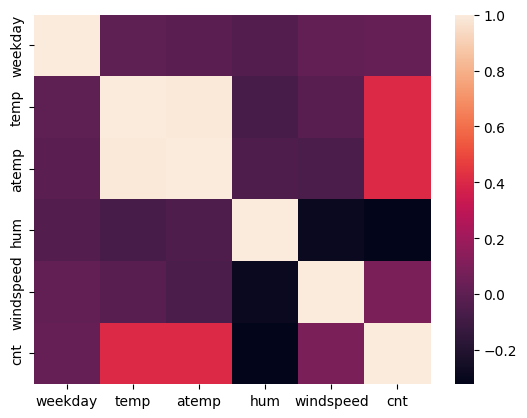

In [5]:
sns.heatmap(df.corr(numeric_only=True))

En este mapa de calor podemos visualizar que las varibles que más se relacionan a la variable objetivo son **atemp** y **temp** luego de estas se encuntran las variables **windspeed** y **weekday** y por ultimo la variable **hum**, la cual tiene una relación negativa.

### **Selección de variables categoricas:** 
Para conocer la dependencia de las variables categoricas (season', 'weathersit' y 'time_of_day') con respecto a la variable objetivo **"cnt"** se usara el metodo de analisis de varianza **(ANOVA)**, ya que estas variables cuentan con mas de 2 categorias.**Es importante realizar el encoded de los datos antes de realizar el análisis de ANOVA**

In [6]:
# Seleccionar las columnas de interés para el análisis de ANOVA
columns_of_interest = ['season', 'weathersit', 'time_of_day', 'cnt']

# Crear un DataFrame con las columnas de interés
datos_r_subset = df[columns_of_interest]

# Codificar las variables categóricas 'season', 'weathersit', 'time_of_day' en valores numéricos utilizando one-hot encoding
datos_r_encoded = pd.get_dummies(datos_r_subset, columns=['season', 'weathersit', 'time_of_day'], drop_first=True)

# Realizar un ANOVA en la variable numérica 'cnt' en relación con las variables codificadas
independent_variables = datos_r_encoded.columns.tolist()
independent_variables.remove('cnt')  # Eliminar la variable objetivo 'cnt'

anova_results = {}

for feature in independent_variables:
    groups = [datos_r_encoded[datos_r_encoded[feature] == category]['cnt'] for category in datos_r_encoded[feature].unique()]
    f_statistic, p_value = f_oneway(*groups)
    anova_results[feature] = {'F-statistic': f_statistic, 'p-value': p_value}

# Mostrar los resultados del ANOVA
for feature, results in anova_results.items():
    print(f"Variable independiente: {feature}")
    print(f"F-statistic: {results['F-statistic']}")
    print(f"P-value: {results['p-value']}")
    if results['p-value'] < 0.05:
        print("La variable es significativa en relación con la variable objetivo.")
    else:
        print("La variable no es significativa en relación con la variable objetivo.")
    print()


Variable independiente: season_Spring
F-statistic: 64.24458464411748
P-value: 1.168134896669792e-15
La variable es significativa en relación con la variable objetivo.

Variable independiente: season_Summer
F-statistic: 408.8768376670813
P-value: 6.952100039941956e-90
La variable es significativa en relación con la variable objetivo.

Variable independiente: season_Winter
F-statistic: 1114.0574882272413
P-value: 8.231700042557857e-237
La variable es significativa en relación con la variable objetivo.

Variable independiente: weathersit_Heavy Rain
F-statistic: 1.2088193952233581
P-value: 0.2715812954262487
La variable no es significativa en relación con la variable objetivo.

Variable independiente: weathersit_Light Rain
F-statistic: 289.60547118812985
P-value: 2.015540639707772e-64
La variable es significativa en relación con la variable objetivo.

Variable independiente: weathersit_Mist
F-statistic: 38.3097590868338
P-value: 6.171333255744615e-10
La variable es significativa en relació

### **Conclusión del analisis para la selección de las variables numericas y categoricas:** 
De acuerdo con los resultados obtenidos con el mapa de calor (que muestra la dependencia entre variables numericas) se puede definir que las variables numericas que se van a usar son; **"temp"** y **"atemp"** ya que tienen algo de relación con la variable objetivo. Por otro lado las variables categoricas que se van a usar seran; **"season"**, **"weathersit"** y **time_of_day**.

## 2. Limpieza y preparación de los datos

En esta etapa se procede a limpiar los datos (eliminar valores NaN y duplicados) y prepararlos (encoded de las variables categoricas) para usarlos como parametros de entrada para el modelo. **Antes de proceder con este paso se debe definir una variable (data) en donde se almacena el conjunto de datos modificado.**

In [7]:
data = df

### **Eliminar valores nulos (NaN values):** 
Inicialmente se debe usar la funcion .isna() junto con la funcion .sum() para conocer si hay valores NaN presentes en alguna de las columnas.

In [8]:
data.isna().sum()

season         0
weekday        0
weathersit     0
temp           0
atemp          0
hum            0
windspeed      0
cnt            0
time_of_day    0
dtype: int64

Esto nos indica que no hay valores NaN dentro de las columnas, por lo tanto no se debe eliminar nada en este paso.

### **Eliminar valores duplicados:** 
Es importante conocer los valores duplicados, ya que si se tienen muchos datos repetidos al realizar el entrenamiento, el modelo resultante no podrá generalizar correctamente cuando deba evaluar datos nuevos, sino que estará sobreajustado o sesgado hacia los datos duplicados. Para ello usamos la función .duplicated() junto a .sum().

In [9]:
data.duplicated().sum()

42

Ya que se tienen 42 valores duplicados se debe proceder a eliminarlos.

In [10]:
data.drop_duplicates(inplace=True)

Se usa el parametro **inplace=True** para guardar en el dataframe **"data"** los datos sin los valores duplicados. Sin este parametro no se veria reflejada la modificación en el dataframe.

Usamos la funcion .info() para asegurarnos que se haya ejecutado los cambios (eliminación de duplicados) en el dataframe (data).

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17337 entries, 0 to 17378
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       17337 non-null  object 
 1   weekday      17337 non-null  int64  
 2   weathersit   17337 non-null  object 
 3   temp         17337 non-null  float64
 4   atemp        17337 non-null  float64
 5   hum          17337 non-null  float64
 6   windspeed    17337 non-null  float64
 7   cnt          17337 non-null  int64  
 8   time_of_day  17337 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 1.3+ MB


### **Eliminar variables poco revelantes:** 
Segun el analisis realizado en el paso 1 (Exploración y perfilamiento de datos) se procede a eliminar las columnas de las variables poco relevantes para el modelo (windspeed, hum y weekday).

In [12]:
data = data.drop(['windspeed','hum','weekday'], axis=1)

Se observa el resultado con la funcion .head()

In [13]:
data.head()

,season,weathersit,temp,atemp,cnt,time_of_day
0,Winter,Clear,3.28,3.0014,16,Night
1,Winter,Clear,2.34,1.9982,40,Night
2,Winter,Clear,2.34,1.9982,32,Night
3,Winter,Clear,3.28,3.0014,13,Night
4,Winter,Clear,3.28,3.0014,1,Night


### **Modificar las variables categoricas por valores numericos:** 
Debido a que las variables categoricas contienen valores tipo string se debe hacer un one-hot encoding para convertir estos valores en numeros (int).

Para esto se usa la función `get_dummies()` y se almacena el nuevo dataframe en la variable data.

In [14]:
data = pd.get_dummies(data, columns=['season','weathersit','time_of_day'], drop_first=True)

Usamos la función `.head()` para visualizar que los cambios se hayan efectuado en el dataframe.

In [15]:
data.head()

,temp,atemp,cnt,season_Spring,season_Summer,season_Winter,weathersit_Heavy Rain,weathersit_Light Rain,weathersit_Mist,time_of_day_Morning,time_of_day_Night
0,3.28,3.0014,16,0,0,1,0,0,0,0,1
1,2.34,1.9982,40,0,0,1,0,0,0,0,1
2,2.34,1.9982,32,0,0,1,0,0,0,0,1
3,3.28,3.0014,13,0,0,1,0,0,0,0,1
4,3.28,3.0014,1,0,0,1,0,0,0,0,1


Y tambien `.info()` para ver que no se hayan modificado el numero de filas.

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17337 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temp                   17337 non-null  float64
 1   atemp                  17337 non-null  float64
 2   cnt                    17337 non-null  int64  
 3   season_Spring          17337 non-null  uint8  
 4   season_Summer          17337 non-null  uint8  
 5   season_Winter          17337 non-null  uint8  
 6   weathersit_Heavy Rain  17337 non-null  uint8  
 7   weathersit_Light Rain  17337 non-null  uint8  
 8   weathersit_Mist        17337 non-null  uint8  
 9   time_of_day_Morning    17337 non-null  uint8  
 10  time_of_day_Night      17337 non-null  uint8  
dtypes: float64(2), int64(1), uint8(8)
memory usage: 677.2 KB


## 3. Construcción de un modelo de regresión polinomial

Luego de tener los datos ya listos para el modelo se procede a contruir un modelo de regresión lineal. Para ello debemos primero dividir las variables independientes (x) de la variable dependiente (y)

In [17]:
x = data.drop(['cnt'], axis=1)
y = data['cnt']

In [18]:
x.head()

,temp,atemp,season_Spring,season_Summer,season_Winter,weathersit_Heavy Rain,weathersit_Light Rain,weathersit_Mist,time_of_day_Morning,time_of_day_Night
0,3.28,3.0014,0,0,1,0,0,0,0,1
1,2.34,1.9982,0,0,1,0,0,0,0,1
2,2.34,1.9982,0,0,1,0,0,0,0,1
3,3.28,3.0014,0,0,1,0,0,0,0,1
4,3.28,3.0014,0,0,1,0,0,0,0,1


Poseriormente se dividen los datos de prueba y entrenamiento usando `train_test_split()`.

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=77)

### Estandarización

Se crean nuevas variables a partir del modelo de referencia, para esto es importante dejar las variables en la misma escala por eso se hace uso de la clase `RobustScaler()` y se almacena en la variable **scaler**.

In [20]:
scaler = RobustScaler()

Para realizar la estandarización se usa el metodo `fit_transform()` lo cual va a retornar un arreglo, pero como lo que se necesita es un Dataframe, entonces se debe almacenar la información de las columnas en una variable llamada **columns**.

In [21]:
columns = x_train.columns
x_train = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train, columns=columns)

### Entrenamiento de un modelo de referencia

Se entrena el modelo de regresión lineal sin ninguna modificación, usando los conjuntos de entrenamiento y pruebas que se definieron anteriormente:

In [22]:
reg_lineal = LinearRegression().fit(x_train, y_train)

In [23]:
list(zip(x_train.columns, reg_lineal.coef_))

[('temp', 104.40221395998643),
 ('atemp', 5.733928511904791),
 ('season_Spring', -31.28647806925295),
 ('season_Summer', -67.64803272318541),
 ('season_Winter', -47.274336029626824),
 ('weathersit_Heavy Rain', -54.05045904372837),
 ('weathersit_Light Rain', -81.84293062476861),
 ('weathersit_Mist', -21.53386792478922),
 ('time_of_day_Morning', -106.3329279867691),
 ('time_of_day_Night', -211.90322271865466)]

#### Evaluación del modelo

Primero se usa la variable `scaler` para escalar las variables independientes del conjunto de pruebas. Ya que se utiliza solo la información de los datos de entrada del conjunto de datos de entrenamiento se hace uso del método `transform()` en vez del método `fit_transform()`:

In [24]:
x_test = scaler.transform(x_test)
x_test = pd.DataFrame(x_test, columns=columns)

Despues de haber dejado las variables del modelo en la misma escala, se procede a evaluar el ajuste del modelo con la metrica de desviación cuadratica media (**RMSE**).

In [25]:
y_pred_lineal = reg_lineal.predict(x_test)

print('------ Modelo de regresión lineal simple----')
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred_lineal, squared=False))

------ Modelo de regresión lineal simple----
RMSE: 141.84


Como se puede observar, el modelo de regresión lineal tiene un **RMSE de 105.85**. Veremos si es posible mejorar el rendimiento utilizando regresión polinomial.

### Entrenamiento de un modelo de regresión polinomial

Teniendo el modelo de referencia, vamos a entrenar un modelo utilizando regresión polinomial. Partiremos nuevamente desde el conjunto de datos sin estandarizar, por lo que volveremos a utilizar `train_test_split()` para volver a obtener los conjuntos de entrenamiento y pruebas originales:

In [26]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=77)

Usaremos los conjuntos de datos separados, pero vamos a incluir un paso adicional antes del entrenamiento, la transformación de datos.

#### Transformación de datos (Polinomio segundo grado)

En este paso ae define el grado maximo del polinomio, que en este caso sera un polinomio de grado 2, lo cual genera un nuevo conjunto de datos.

In [27]:
pf_2 = PolynomialFeatures(degree=2)

Utilizaremos `fit_transform()` para modificar nuestro conjunto de variables independientes, almacenando el resultado en `x_train_pol2`:

In [28]:
x_train_pol2 = pf_2.fit_transform(x_train)
x_train_pol2

array([[ 1.    ,  9.86  ,  9.9974, ...,  1.    ,  0.    ,  0.    ],
       [ 1.    , 23.96  , 26.0024, ...,  1.    ,  0.    ,  0.    ],
       [ 1.    , 20.2   , 22.9994, ...,  0.    ,  0.    ,  1.    ],
       ...,
       [ 1.    ,  6.1   ,  5.9978, ...,  0.    ,  0.    ,  1.    ],
       [ 1.    ,  8.92  ,  7.001 , ...,  1.    ,  0.    ,  0.    ],
       [ 1.    , 17.38  , 18.0032, ...,  1.    ,  0.    ,  0.    ]])

En este conjunto de datos tenemos 6 variables independientes, por lo que usaremos `x_train_pol2.shape` para ver cuántos términos se generan:

In [29]:
x_train_pol2.shape

(13869, 66)

Como puedes observar, tenemos 66 variables que representan todas las combinaciones polinomiales en un polinomio de grado 2 con 6 variables. 

#### Estandarización

Después de realizar la transformación, aplicaremos el objeto `RobustScaler()` sobre nuestro nuevo conjunto de 66 variables, haciendo uso del método `fit_transform()`:

In [30]:
scaler_pol2 = RobustScaler()
x_train_pol2 = scaler_pol2.fit_transform(x_train_pol2)

#### Entrenamiento del modelo

Ahora entrenaremos el modelo con los datos del conjunto de entrenamiento, almacenando el resultado en la variable `reg_polinomial`:

In [31]:
reg_polinomial = LinearRegression().fit(x_train_pol2, y_train)

Para realizar las predicciones, primero vamos a realizar la transformación de los datos del conjunto de pruebas: 

In [32]:
x_test_pol2 = pf_2.transform(x_test)

In [33]:
x_test_pol2 = scaler_pol2.transform(x_test_pol2)

Luego de realizar las transformaciones pertienetes de este modelo de regresión polinomial de grado 2, se procede a evaluar el modelo con la metrica **RMSE**.

In [34]:
y_pred_pol_2 = reg_polinomial.predict(x_test_pol2)

print('------ Modelo de regresión polinomial múltiple (grado 2)----')
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred_pol_2, squared=False))

------ Modelo de regresión polinomial múltiple (grado 2)----
RMSE: 139.23


#### Transformación de datos (Polinomio de tercer grado)

In [35]:
pf_3 = PolynomialFeatures(degree=3)

Siguiendo el proceso para el modelo anterior, vamos a transformar el conjunto de entrenamiento:

In [36]:
x_train_pol3 = pf_3.fit_transform(x_train)

Además, realizaremos la estandarización del nuevo conjunto de variables con otro objeto de la clase `RobustScaler()`:

In [37]:
scaler_pol3 = RobustScaler()
x_train_pol3 = scaler_pol3.fit_transform(x_train_pol3)

Veremos la cantidad de variables generadas usando `x_train_pol.shape`:

In [38]:
x_train_pol3.shape

(13869, 286)

Como puedes ver, aumentar en uno el valor del hiperparámetro aumenta la cantidad de variables de 55 a 220, lo que implica un salto considerable de complejidad. Vamos a entrenar el modelo y almacenaremos el resultado en `reg_polinomial`: 

In [39]:
reg_polinomial = LinearRegression().fit(x_train_pol3, y_train)

Para evaluar el modelo vamos a transformar los datos del conjunto de pruebas:

In [40]:
x_test_pol3 = pf_3.transform(x_test)

Y realizaremos la transformación utilizando el método `transform()` del objeto `scaler_pol3`:

In [41]:
x_test_pol3 = scaler_pol3.transform(x_test_pol3)

Finalmente, realizaremos las predicciones para el polinomio de grado 3:

In [42]:
y_pred_pol_3 = reg_polinomial.predict(x_test_pol3)

print('------ Modelo de regresión polinomial múltiple (grado 3)----')
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred_pol_3, squared=False))

------ Modelo de regresión polinomial múltiple (grado 3)----
RMSE: 136.83


## 4. Regresión regularizada de Lasso

Lo primero que haremos es definir un objeto de tipo `Lasso()`, que puede recibir un valor del hiperparámetro `alpha`. En este caso, al cambiar su valor durante la búsqueda, no es necesario especificarlo. Sin embargo, vamos a definir el parámetro `max_iter` para aumentar el número de iteraciones y, de esa forma, ayudar a la convergencia del modelo:

In [43]:
lasso = Lasso(max_iter=2000)

Ahora utilizaremos un diccionario para definir nuestro espacio de búsqueda de hiperparámetros, es decir, los valores que vamos a probar y sobre los que decidiremos cuál escoger. Almacenaremos estos valores en la variable `param_grid`:

In [44]:
param_grid = {'alpha': [1, 2, 3, 4, 5]}

Además vamos a definir un objeto de la clase `KFold()`, que nos será útil para obtener una estimación del desempeño del modelo más realista que simplemente utilizando el conjunto de pruebas. La validación cruzada k-fold es un método que toma el conjunto de entrenamiento original y lo separa en k grupos, usando uno como validación y el resto (k-1) como entrenamiento. Después de definir los grupos, entrena el modelo con el conjunto de entrenamiento y lo evalúa con el conjunto de validación, repitiendo este proceso para cada uno de los k grupos. En este caso, definiremos `k=10` y usaremos el parámetro `shuffle=True` para indicar que se cambie el orden de los datos antes de separarlos en los grupos:

In [45]:
kfold = KFold(n_splits=10, shuffle=True, random_state = 77)

A continuación, vamos a utilizar `GridSearchCV` para realizar la búsqueda exhaustiva del mejor hiperparámetro. Definiremos el algoritmo `lasso`, los valores del hiperparámetro `param_grid` y la estrategia de validación cruzada `kfold`: 

In [46]:
modelos_grid = GridSearchCV(lasso, param_grid, cv=kfold, n_jobs=-1)

Finalmente, entrenaremos los modelos con los conjuntos definidos previamente.

In [47]:
modelos_grid.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=77, shuffle=True),
             estimator=Lasso(max_iter=2000), n_jobs=-1,
             param_grid={'alpha': [1, 2, 3, 4, 5]})

Obtendremos el mejor parámetro usando el atributo `best_params_`:

In [48]:
print("Mejor parámetro: ", modelos_grid.best_params_)

Mejor parámetro:  {'alpha': 1}


Como puedes ver, el mejor valor del hiperparámetro `alpha` es 1. Podemos obtener el mejor modelo haciendo uso del atributo `best_estimator_`, y obtendremos sus coeficientes usando el atributo `coef_`:

In [49]:
mejor_modelo = modelos_grid.best_estimator_
list(zip(x_train.columns, mejor_modelo.coef_))

[('temp', 6.355508749637381),
 ('atemp', 0.6506256165609132),
 ('season_Spring', -14.127433190181835),
 ('season_Summer', -48.23041147198603),
 ('season_Winter', -31.61425906989949),
 ('weathersit_Heavy Rain', -0.0),
 ('weathersit_Light Rain', -65.94734411116934),
 ('weathersit_Mist', -14.253994407808605),
 ('time_of_day_Morning', -97.6176177209234),
 ('time_of_day_Night', -203.02422243213434)]

#### Evaluación del modelo de Regresión estandarizada de Lasso

Evaluamos la predicción de njuestro modelo con la metrica **RMSE**.

In [50]:
y_pred_lasso = mejor_modelo.predict(x_test)

print('------ Modelo de regresión Lasso----')
print("RMSE: %.2f" % mean_squared_error(y_test, y_pred_lasso, squared=False))

------ Modelo de regresión Lasso----
RMSE: 141.96


## 5. Tabla comparativa de los modelos.

En esta tabla comparativa se muestra las metricas de cada uno de los modelos evaluados, para poder seleccionar los 2 que obtuvieron el mejor rendimiento.

In [51]:
# Crear un diccionario con los valores de las métricas para cada modelo
data = {
    'Model': ['Regresión Lineal', 'Regresión Polinomial Grado 2', 'Regresión Polinomial Grado 3', 'Regresión Estandarizada de Lasso'],
    'R^2': [r2_score(y_test, y_pred_lineal), r2_score(y_test, y_pred_pol_2), r2_score(y_test, y_pred_pol_3), r2_score(y_test, y_pred_lasso)], 
    'RMSE': [mean_squared_error(y_test, y_pred_lineal, squared=False), mean_squared_error(y_test, y_pred_pol_2, squared=False), mean_squared_error(y_test, y_pred_pol_3, squared=False), mean_squared_error(y_test, y_pred_lasso, squared=False)], 
    'MAE': [mean_absolute_error(y_test, y_pred_lineal), mean_absolute_error(y_test, y_pred_pol_2), mean_absolute_error(y_test, y_pred_pol_3), mean_absolute_error(y_test, y_pred_lasso)]  
        }

# Crear un DataFrame a partir del diccionario
results_df = pd.DataFrame(data)

# Ordenar el DataFrame por la métrica deseada en orden descendente
metric_to_highlight = 'RMSE'  
results_df = results_df.sort_values(by=metric_to_highlight, ascending=False)

# Colorear las dos mejores filas
def highlight_best(s):
    best = s.nsmallest(2).index
    is_best = s.index.isin(best)
    return ['background-color: yellow' if v else '' for v in is_best]

# Mostrar la tabla comparativa con las mejores filas resaltadas
styled_df = results_df.style.apply(highlight_best, subset=[metric_to_highlight])
styled_df

,Model,R^2,RMSE,MAE
3,Regresión Estandarizada de Lasso,0.400531,141.956755,105.772629
0,Regresión Lineal,0.401522,141.839446,105.908877
1,Regresión Polinomial Grado 2,0.423316,139.232873,102.434062
2,Regresión Polinomial Grado 3,0.443080,136.826243,100.301441


Como se puede ver en la tabla los modelos que mejor rendimiento tienen son los modelos de regresión polinomial de grado 2 y 3.

## 6. Variables mas importantes para la predicción.

Si se entrena un modelo de regresión Lasso con un valor alto de `alpha`, la regularización puede llegar a anular los coeficientes de algunas variables. Este comportamiento permite realizar una selección de las variables menos importantes, anulando su influencia en las predicciones de la variable objetivo. Usando nuestro conjunto de datos, vamos a definir un objeto de tipo `Lasso()`, pero esta vez utilizando un valor de `alpha` de 500:

In [52]:
lasso_sv = Lasso(alpha=500)

Entrenaremos el modelo utilizando el conjunto de entrenamiento:

In [53]:
lasso_sv.fit(x_train, y_train)

Lasso(alpha=500)

Y obtendremos los coeficientes resultantes:

In [54]:
list(zip(x_train.columns, lasso_sv.coef_))

[('temp', 0.0),
 ('atemp', 2.4543284488294366),
 ('season_Spring', 0.0),
 ('season_Summer', 0.0),
 ('season_Winter', -0.0),
 ('weathersit_Heavy Rain', -0.0),
 ('weathersit_Light Rain', -0.0),
 ('weathersit_Mist', -0.0),
 ('time_of_day_Morning', 0.0),
 ('time_of_day_Night', -0.0)]

Segun la regresión estandarizada de Lasso nuestro modelo depende basicamente de una sola variable y esta es la variable **'atemp'**.

## 7. Analisis de resultados

#### 1. ¿Cuál es el grado de la transformación polinomial que fue seleccionado utilizando la técnica de validación?

El grado de transformación polinomial que mejoro la predicción del modelo de regresión inicial fue el grado 3, ya que sus metricas fueron las de mejor resultado.

#### 2. ¿Cuál fue el valor de α que fue seleccionado utilizando la técnica de validación para la regresión Lasso?

El valor de alfa que da una mejor predicción para el modelo de regresión inicial es el valor de 1. Aunque este valor es muy similar al obtenido con la regresión lineal (sin transformaciones), por lo tanto no se ve mejoria al aplicar la regresión estandarizada de Lasso.

#### 3. A partir de la tabla comparativa, ¿cuál modelo ofrece el mejor rendimiento sobre el conjunto test? ¿Qué interpretación puedes darles a los valores obtenidos sobre las métricas de rendimiento?

El modelo que ofrece mejor rendimiento es el de regresión polinomial de tercer grado, aunque al ser de 3 grado puede tener alta complejidad y sea mas dificil entrenar el modelo dado el numero de variables que se obtienen.

#### 4. ¿Cuáles variables fueron seleccionadas con el modelo Lasso? A partir de estas, ¿qué interpretación de cara al problema puedes dar? Reflexiona sobre cómo este nuevo conocimiento podría ayudar a tomar decisiones en el contexto del problema.

Según el modelo de regresion de Lasso (L1) la unica variable que me puede aportar para realizar una predicción sobre la demanda del uso de un sistema de alquiler de bicicletas es la tempertatura del día ('temp'), lo que indica que seria ideal obtener otras variables que esten mas relacionadas con el nivel de satifacción de los usuarios que usan este sistema y tambien observar los patrones en las zonas donde se tiene implementado este sistema.

Desarrollado por **DANILO ALFONSO DUARTE** para la materia Principios de machine learning de la Maestria de Inteligencia Artificial. 